<a href="https://colab.research.google.com/github/paulo-antunes-1/paulo-antunes-atmospheric-data/blob/main/MERRA2_Aerosols/MERRA_AOD_EOF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q netCDF4 numpy xarray geopandas cartopy eofs matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 60.5 MB/s eta 0:00:00


In [3]:
# Import libraries
import os
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from eofs.xarray import Eof

In [6]:
ds_merra = xr.open_dataset('/content/drive/MyDrive/AOD_ANUAL_MERRA-2.nc')
ds_merra

<xarray.Dataset> Size: 18MB
Dimensions:                  (time: 21, lat: 361, lon: 576, latv: 2, lonv: 2)
Coordinates:
  * lat                      (lat) float64 3kB -90.0 -89.5 -89.0 ... 89.5 90.0
  * lon                      (lon) float64 5kB -180.0 -179.4 ... 178.8 179.4
Dimensions without coordinates: time, latv, lonv
Data variables:
    M2IMNXGAS_5_12_4_AODANA  (time, lat, lon) float32 17MB ...
    lat_bnds                 (time, lat, latv) float64 121kB ...
    lon_bnds                 (time, lon, lonv) float64 194kB ...
Attributes:
    Conventions:               CF-1.4
    start_time:                2003-01-01T00:00:00Z
    end_time:                  2004-01-31T23:59:59Z
    NCO:                       netCDF Operators version 5.0.6 (Homepage = htt...
    nco_openmp_thread_number:  1
    history:                   Mon Nov 11 20:48:43 2024: ncks -O -x -v time_b...
    userstartdate:             2003-01-01T00:00:00Z
    userenddate:               2004-01-31T23:59:59Z
    title:                     Time Averaged Map of Aerosol Optical Depth Ana...
    plot_hint_title:           Time Averaged Map of Aerosol Optical Depth Ana...
    plot_hint_subtitle:        over 2003-Jan - 2004-Jan

In [9]:
# Abrir o dataset e selecionar a variável desejada
aod_merra_w = ds_merra['M2IMNXGAS_5_12_4_AODANA']

# Selecionar a região, se necessário (ex: América do Sul e África)
aod_merra_w = aod_merra_w.sel(lat=slice(-70, 70))

# Calcular pesos latitude (sqrt(cos(lat))) e expandir para lat/lon
coslat = np.cos(np.deg2rad(aod_merra_w['lat']))
weights = xr.DataArray(np.sqrt(coslat), dims=['lat']).broadcast_like(aod_merra_w.isel(time=0))

# Aplicar análise EOF
solver_af_sa = Eof(aod_merra_w, weights=weights)

In [10]:
# As coordenadas já estão embutidas no próprio xarray, mas se quiser acessar separadamente:
lats = ds_merra['lat']
lons = ds_merra['lon']

In [11]:
# Remover a média temporal
aod_anom = aod_merra_w - aod_merra_w.mean(dim='time')

# Aplicar análise EOF com pesos corretos
solver = Eof(aod_anom, weights=weights)

# Extrair EOFs como correlação (top 10)
eof1 = solver.eofsAsCorrelation(neofs=10)

# PCs correspondentes
pc1 = solver.pcs(npcs=10, pcscaling=1)

# Variância explicada
varfrac = solver.varianceFraction()

# Autovalores
lambdas = solver.eigenvalues()


/tmp/ipython-input-12-3285524706.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('jet')
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


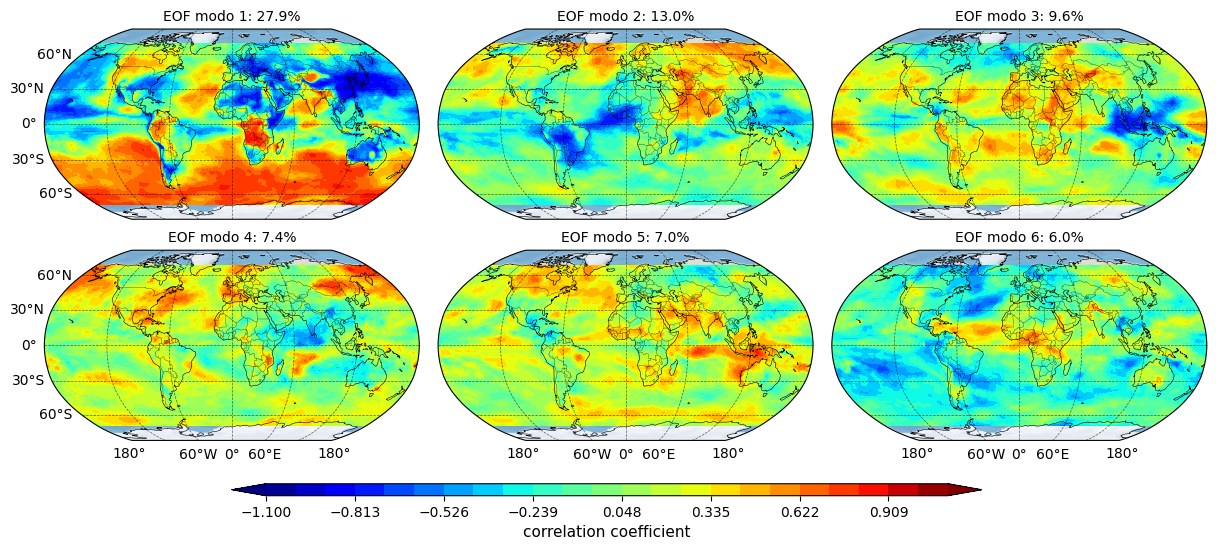

In [12]:
# Parâmetros
modes_to_plot = 6
rows, cols = 2, 3
levels = np.linspace(-1.1, 1.1, 24)
cmap = plt.cm.get_cmap('jet')
norm = mcolors.TwoSlopeNorm(vmin=-1.1, vcenter=0, vmax=1.1)

lats = eof1['lat'].values
lons = eof1['lon'].values

# Figura com menos espaço vertical e sem white-space entre subplots
fig, axs = plt.subplots(
    nrows=rows, ncols=cols, figsize=(15, 6),
    subplot_kw={'projection': ccrs.Robinson()},
    gridspec_kw={'hspace': 0.02, 'wspace': 0.05}
)

axs = axs.ravel()
contour_set = None

for i in range(modes_to_plot):
    ax = axs[i]
    ax.set_global()
    ax.coastlines(linewidth=0.4)
    ax.add_feature(cfeature.BORDERS, linewidth=0.2)
    ax.stock_img()

    contour = ax.contourf(
        lons, lats, eof1[i, :, :],
        levels=levels, cmap=cmap, norm=norm,
        transform=ccrs.PlateCarree(), extend='both'
    )

    if contour_set is None:
        contour_set = contour

    # Título com variação explicada
    var_pct = varfrac[i].values * 100
    ax.set_title(f'EOF modo {i+1}: {var_pct:.1f}%', fontsize=10)

    # Gridlines discretos e visíveis
    gl = ax.gridlines(
        draw_labels=True,
        linewidth=0.5, color='black', alpha=0.6, linestyle='--',
        x_inline=False, y_inline=False,
        crs=ccrs.PlateCarree()
    )
    gl.top_labels = gl.right_labels = False
    gl.left_labels = (i % cols == 0)
    gl.bottom_labels = (i // cols == rows - 1)


# === AJUSTE ESPAÇOS ===
fig.subplots_adjust(bottom=0.15)

# Colorbar unificada
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])  # posição ajustada
cbar = fig.colorbar(contour_set, cax=cbar_ax, orientation='horizontal')
cbar.set_label('correlation coefficient', fontsize=11)

# Salvar e mostrar
plt.savefig('EOF_MODIS_FINAL_REPLICA.png', dpi=300, bbox_inches='tight')
plt.show()
